# Cross-Correlation with `halomod`

The cornerstone of `halomod` is the `TracerHaloModel`, which defines the behaviour of dark matter halos and **one** specific tracer within them. If you want to cross-correlate different tracers, extracting different quantities from two different halo models and calculate the cross-correlation outside `halomod` can be quite tedious. Instead, you can use `CrossCorrelations` framework.

In [1]:
import numpy as np
from halomod.cross_correlations import CrossCorrelations,_HODCross, ConstantCorr
import matplotlib.pyplot as plt

A `CrossCorrelations` object essentially needs three inputs: halo models for two different tracers, and a `cross_hod_model` to specify how these two tracers cross-correlate, which typically should be constructed by users themselves. Let's first use a very basic `ConstantCorr` relation (we'll go back to what it is later):

In [2]:
cross = CrossCorrelations(cross_hod_model=ConstantCorr, 
                          halo_model_1_params=dict(z=1.0),
                          halo_model_2_params=dict(z=0.0))

This defines the cross-correlation between the same galaxy distribution (the default `Zehavi05`) at `z=1.0` and `z=0.0`.

The two halo models within the cross-correlation can be easily extracted and manipulated as they are just `TracerHaloModel` objects. For example, if we want to change the redshift of the cross-correlation:

In [3]:
print(cross.halo_model_1.z)
cross.halo_model_1.z = 0.5
print(cross.halo_model_1.z)

1.0
0.5


The various two-point statistics of this cross-correlation:

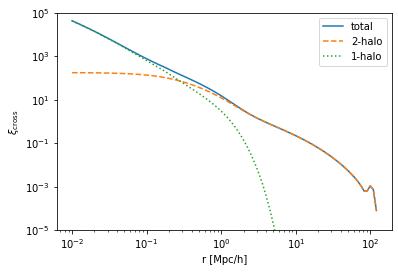

In [6]:
plt.plot(cross.halo_model_1.r,cross.corr_cross-1, ls='-', label='total')
plt.plot(cross.halo_model_1.r,cross.corr_2h_cross, ls='--', label='2-halo')
plt.plot(cross.halo_model_1.r,cross.corr_1h_cross, ls=':', label='1-halo')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5,1e5)
plt.legend()
plt.ylabel(r'$\xi_{\rm cross}$')
plt.xlabel(r'r [Mpc/h]');

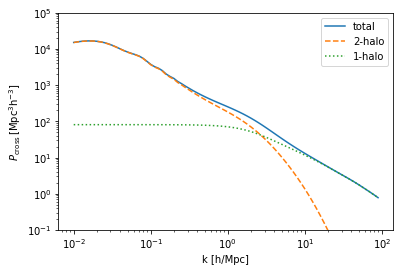

In [7]:
plt.plot(cross.halo_model_1.k_hm,cross.power_cross, ls='-', label='total')
plt.plot(cross.halo_model_1.k_hm,cross.power_2h_cross, ls='--', label='2-halo')
plt.plot(cross.halo_model_1.k_hm,cross.power_1h_cross, ls=':', label='1-halo')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1,1e5)
plt.legend()
plt.ylabel(r'$P_{\rm cross}\,[{\rm Mpc^3 h^{-3}}]$')
plt.xlabel(r'k [h/Mpc]');

Now let's get to the difficult part of `cross_hod`. To understand how to construct it we need to go through the math first. The 2-halo term is easy enough:

$$
P_{\rm 2h}^{\rm ij}(k) = b_{\rm i}(k) b_{\rm j}(k) P_m (k),
$$
where $b_{\rm i,j}$ is the effective bias of tracers i,j against the underlying matter power spectrum

$$
b_{\rm i,j} = \frac{1}{\bar{\rho}_{\rm i,j}} \int {\rm d}m\,n(m)\, b(m)\, \langle T_{\rm i}(m) \rangle\, \tilde{u}_{\rm i}(k|m).
$$
Here $\rho$ is the density of the tracer, $n(m)$ is the halo mass function, $b(m)$ is the linear halo bias, $\langle T_{\rm i}(m) \rangle$ is the total HOD and $\tilde{u}_{\rm i}(k|m)$ is the normalized satellite density profile in Fourier space.

As shown above, the 2-halo term can be determined entirely by the halo models of the two tracers with no extra information needed. However, it is not the case with 1-halo term:

$$
\begin{split}
P_{\rm 1h}^{\rm ij}(k) = \frac{1}{\bar{\rho}_{\rm i}\bar{\rho}_{\rm j}}\int {\rm d}m\,n(m) \Big[& \langle T_{\rm i}^{\rm c} T_{\rm j}^{\rm s} \rangle u_{\rm j}(k|m)\\
+&\langle T_{\rm i}^{\rm s} T_{\rm j}^{\rm c} \rangle u_{\rm i}(k|m)\\
+&\langle T_{\rm i}^{\rm s} T_{\rm j}^{\rm s} \rangle u_{\rm i}(k|m)u_{\rm j}(k|m)
\Big]
\end{split}
$$
where c,s denotes centre and satellite components. The problem here is that we don't know how different $\langle T_{\rm i}^{\rm c,s} T_{\rm j}^{\rm c,s} \rangle$ correlates.

The way `halomod` deals with this is to define:
$$
\langle T_{\rm i}^{\rm c} T_{\rm j}^{\rm s} \rangle = \langle T_{\rm i}^{\rm c} \rangle
\langle T_{\rm j}^{\rm s} \rangle + \sigma_{\rm i}^{\rm c}\sigma_{\rm j}^{\rm s} R_{\rm ij}^{\rm cs}
$$
$$
\langle T_{\rm i}^{\rm s} T_{\rm j}^{\rm c} \rangle = \langle T_{\rm i}^{\rm s} \rangle
\langle T_{\rm j}^{\rm c} \rangle + \sigma_{\rm i}^{\rm s}\sigma_{\rm j}^{\rm c} R_{\rm ij}^{\rm sc}
$$
$$
\langle T_{\rm i}^{\rm s} T_{\rm j}^{\rm s} \rangle = \langle T_{\rm i}^{\rm s} \rangle
\langle T_{\rm j}^{\rm s} \rangle + \sigma_{\rm i}^{\rm s}\sigma_{\rm j}^{\rm s} R_{\rm ij}^{\rm ss} - Q
$$
where $\sigma^{\rm c,s}$ is the standard deviation of HOD, $-1\leq R_{\rm ij} \leq 1$ describes the correlation between two probes and $Q$ is the expected number of self-pairs at zero separation. These quantities are, to first order, functions of halo mass $m$. Note $R_{\rm ij}^{\rm cs}$ and $R_{\rm ij}^{\rm sc}$ are two different quantities.


With this in mind we can define our `cross_hod`. Suppose we want to cross-correlate two different galaxy samples that follows different HOD. The base class of it is `_HODCross`, upon which we construct some model. For simplicity, let us consider the scenario where $R_{\rm ij}$ are some constants and there are no self-pairs:

In [8]:
class ConstantCorr(_HODCross):
    """Correlation relation for constant cross-correlation pairs"""

    _defaults = {"R_ss": 0.0, "R_cs": 0.0, "R_sc": 0.0}

    def R_ss(self, m):
        return self.params["R_ss"]

    def R_cs(self, m):
        return self.params["R_cs"]

    def R_sc(self, m):
        return self.params["R_sc"]

    def self_pairs(self, m):
        """The expected number of cross-pairs at a separation of zero."""
        return 0

Note this is just an illustration and this class is already included in `halomod` as we imported it above. Constructing  `CrossCorrelations`:

In [9]:
cross = CrossCorrelations(cross_hod_model=ConstantCorr, 
                          halo_model_1_params=dict(hod_model = 'Zehavi05'),
                          halo_model_2_params=dict(hod_model = 'Zheng05'))

We can update the parameters $R_{\rm ij}$:

In [11]:
cross.cross_hod_params = dict(R_ss = 1.0,R_sc = 1.0,R_cs = 1.0)
power_1_tot = cross.power_cross
power_1_2h = cross.power_2h_cross
power_1_1h = cross.power_1h_cross

In [12]:
cross.cross_hod_params = dict(R_ss = 0.0,R_sc = 0.0,R_cs = 0.0)
power_2_tot = cross.power_cross
power_2_2h = cross.power_2h_cross
power_2_1h = cross.power_1h_cross

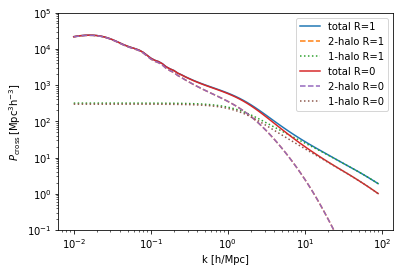

In [13]:
plt.plot(cross.halo_model_1.k_hm,power_1_tot, ls='-', label='total R=1')
plt.plot(cross.halo_model_1.k_hm,power_1_2h, ls='--', label='2-halo R=1')
plt.plot(cross.halo_model_1.k_hm,power_1_1h, ls=':', label='1-halo R=1')
plt.plot(cross.halo_model_1.k_hm,power_2_tot, ls='-', label='total R=0')
plt.plot(cross.halo_model_1.k_hm,power_2_2h, ls='--', label='2-halo R=0')
plt.plot(cross.halo_model_1.k_hm,power_2_1h, ls=':', label='1-halo R=0')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1,1e5)
plt.legend()
plt.ylabel(r'$P_{\rm cross}\,[{\rm Mpc^3 h^{-3}}]$')
plt.xlabel(r'k [h/Mpc]');

As one can see, the 2-halo terms are the same whereas the 1-halo term varies with the choice of R.

When trying to construct a realistic cross-correlation, you may need to find some empirical description of R as functions of halo mass. Furthermore, note that the hod used above are Poisson, and therefore have well-defined $\sigma$ that can be calculated from centre and satellite hod. If you use customized hod models, make sure you define the `sigma_satellite` and `sigma_central` attributes.